[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mir-group/FLARE-Tutorials/blob/master/FLARE_Tutorial_2026.ipynb)

# Learning Many-Body Bayesian Force Fields On-the-Fly: A Tutorial Introduction to the FLARE Code

Materials Intelligence Research Group

Tutorial created by Menghang Wang, Cameron Owen, Yu Xie, and Jonathan Vandermause
> Last update: Jan 30, 2026

<center><img src="https://github.com/mir-group/FLARE-Tutorials/raw/master/OTF/logo.png" width="60%"></center>

<img src="https://github.com/mir-group/FLARE-Tutorials/raw/master/OTF/Team.png" width="100%">

## What will you learn in this tutorial?

  * **Theory review**: Review the principles of FLARE, integration of **ACE descriptors** with **sparse Gaussian Processes (SGPs)**.

  * **Active learning (On-the-Fly Training)**: Train a Bayesian force field using SGP uncertainty quantification with [FLARE](https://github.com/mir-group/flare) code interfaced with the both [ASE MD](#scrollTo=Active_Learning_Framework_in_FLARE) and [LAMMPS MD](#scrollTo=Active_Learning_with_LAMMPS_MD) engines.


  * **Workflow Management**:
    * **Restarts**: Resume interrupted or completed on-the-fly training sessions.
    * **Warm Starts**: Start a new on-the-fly training using a pre-trained SGP model to accelerate convergence.
  
  * **Model Instantiation Parameter Optimization**: Test FLARE model static hyper-parameters prior to training the final force field.

  * **Offline Training & Depolyment**:
    * Train a final Bayesian force field using static DFT datasets, including frames collected from previous active learning loops, without active MD.
    * Export production-ready coefficient files configured for **uncertainty quantification (UQ)** with LAMMPS.


> **Note!!**: Please make a copy of this notebook before running any cells to ensure your changes are saved.**

---



## An example training workflow


In this tutorial, we use aluminum (Al) as a simple case study to demonstrate the complete training pipeline. These scripts are designed to serve as templates that can be easily modified for your own complex systems.
> To facilitate this, we have provided detailed comments throughout the code explaining how to extend the setup to multiple chemical species.

To understand the overall process, the flowchart below illustrates the workflow used to train a reactive Bayesian force field for the H/Pt system, as established in our [1](https://www.nature.com/articles/s41467-022-32294-0) and [2](https://arxiv.org/abs/2204.12573).

![](https://mermaid.ink/svg/pako:eNp90MFqwzAMBuBXET4lkDLYMYdBt6bNYYey7eiLmsiJmOMUW2GMpO8-p14vPdQngT9J6J9VM7akStV5PPfw_qEdxLfN6mfoMOSw2bwsxlPoIQh6WaDKttZCi4J5sq_ZUeA02e8rhjutnRYtb6sJFk8PzC6rn6JiJ-QNNvSAVulrNMayIxCP7BbYz-xYGC2Y0TcEhsm2l9SxTx0_6IfbrEPa13PXk4evAo55soerrWfD7m6WKtRAfkBuY2Lzer5W0tNAWpWxjJSCaKXdKqdzDImqlmX0qjRoAxUKJxk_f12jSvET3dCOMeY__KvLHwOth6I)

# Installation

Let's begin by installing the `flare` and dependencies. This will take a few minutes, so make sure to run the blocks right away. While this block is running, you can proceed to the next section, where the underlying theory of the FLARE model is introduced.

### Linear algebra dependencies
If you have MKL on your machine, use MKL, but we are keeping it simple on Google Colab:

In [1]:
%%bash

pip uninstall -y mkl mkl-devel mkl-include
sudo apt-get remove -y *mkl*
sudo apt-get update -y
sudo apt-get install -y libopenblas-dev liblapacke-dev

### FLARE

We clone the Git repository and install from source.

<!-- Install a working copy of lapack/lapacke.
! pip uninstall -y mkl
! sudo apt install liblapacke liblapacke-dev
Install ase
! pip install ase
Switch the Colab C++ compiler to g++-9.
! sudo add-apt-repository -y ppa:ubuntu-toolchain-r/test
! sudo apt update
! sudo apt install gcc-9 g++-9
! update-alternatives --install /usr/bin/gcc gcc /usr/bin/gcc-9 50
! update-alternatives --install /usr/bin/g++ g++ /usr/bin/g++-9 50
!git clone -b development https://github.com/mir-group/flare.git
!cd flare && pip install . -->

In [2]:
! rm -rf flare && git clone -b update-tutorial --depth=1 https://github.com/mir-group/flare
! cd flare && pip install .

In [3]:
import flare
from flare.bffs.sgp import SGP_Wrapper

# Background

You can skip this section if you are already motivated to use machine learned force fields.

## Molecular dynamics

<center><img src="https://github.com/mir-group/FLARE-Tutorials/raw/master/OTF/MD.png" width="60%"></center>

Molecular dynamics simulations primarily consist of the newtonian integration of atomic motion, where atoms are moved according to their forces. These MD trajectories can be carried out using a variety of methods, but there exists an accuracy-cost trade-off between classical, empirical methods and *ab initio* methods like density functional theory. This tradeoff is exemplified below, where we can observe the approximate time- and length-scales of these methods in comparison to one another.

<center><img src="https://github.com/mir-group/FLARE-Tutorials/raw/master/OTF/Tradeoff.png" width="80%"></center>

A major drawback of empirical methods is their accuracy and ability to interpolate between different atomic environments, despite their impressive ability to scale. This limitation in accuracy is due to their fixed functional form, where the user has to fit the force field in a low-dimensional space to experimental or theoretical benchmarks. This process requires nontrivial parameterization of the interatomic forces, where expert chemical intuition and parameter-tuning is typically carried out over the span of months.

### Why do we need machine learning for this use-case?

On the otherhand, machine learned force fields (MLFFs) do not require an explicit parametric form, and can be trained in a fraction of the time. Several formalisms exist for MLFFs, detailed below, where linear models are fast, but less accurate, whereas kernel methods are slow, but accurate and extremely data efficient.

<img src="https://github.com/mir-group/FLARE-Tutorials/raw/master/APS-2020/mb_models2.png" width="100%">

## Many-body Bayesian Force Field of FLARE

### Descriptors

Our approach follows the Gaussian Approximation Potential framework first introduced in Ref. [4] (see [5] for an excellent introduction), with a multi-element generalization of the Atomic Cluster Expansion [6] used to build rotationally-invariant many-body descriptors of local atomic environments.

<img src="https://github.com/mir-group/FLARE-Tutorials/raw/master/APS-2020/mb_descriptors2.png" width="100%">

We'll use the $B_2$ descriptor from the Atomic Cluster Expansion, which requires us to define:

*   The cutoff function and radius.
*   The type and number of radial basis functions.
*   The number of spherical harmonics used to describe each atomic environment.

These are chosen by the user, and it's generally a good idea to check how different choices influence the model accuracy. We provide a script at the end of this tutorial to do just this prior to final training of the model, see [the last section](#scrollTo=Evaluate_Model_Instantiation_Parameters).

The parameters provided below have been found to provide reasonable results for most systems, where the only difference for systems with more chemical species would be the dimension of the cutoff matrix, where an example is also provided below.

```yaml
    descriptors:
        - name: B2                    # Atomic Cluster Expansion (ACE) descriptor from R. Drautz (2019). FLARE can only go from B1 up to B3 currently.
          nmax: 8                     # Radial fidelity of the descriptor (higher value = higher cost)
          lmax: 3                     # Angular fidelity of the descriptor (higher value = higher cost)
          cutoff_function: quadratic  # Cutoff function
          radial_basis: chebyshev     # Polynomial for radial basis
          cutoff_matrix: [[5.0]]      # (Optional) Interaction cutoffs in angstroms. An N×N matrix for N species.
#         cutoff_matrix: [[5.0,4.0],[4.0,5.0]]      # Example for a 2-species system. Rows and columns correspond to the order of the chemical species list (e.g., element [0,0] is the self-interaction cutoff for the first species).

```

### Kernel

Next, we define our kernel function. We'll use a simple normalized dot product kernel:
\begin{equation}
k(\vec{d}_1, \vec{d}_2) = \sigma \left(\frac{\vec{d}_1 \cdot \vec{d}_2}{d_1 d_2}\right)^2.
\end{equation}

This kernel has proven reliable for a variety of systems, but users are welcome to select from a variety of kernels, as provided in the `flare/kernels` folder in the github, or implement their own.

```yaml
    kernels:
        - name: NormalizedDotProduct                                            # select kernel for comparison of atomic environments
          sigma: 2.0                                                            # signal variance, this hyperparameter will be trained, and is typically between 1 and 10.
          power: 2                                                              # power of the kernel, influences body-order
```

With the kernel object defined, we can construct a sparse GP object. To do this, we need to choose noise values for each type of label that we will learn from: energies, forces, and stresses. It's a good idea to initialize these values to the expected error level for each quantity.

```yaml
    energy_noise: 0.096                                                         # Energy noise hyperparameter, will be trained later. Typically set to 1 meV * N_atoms.
    forces_noise: 0.05                                                          # Force noise hyperparameter, will be trained later. System dependent, typically between 0.05 meV/A and 0.2 meV/A.
    stress_noise: 0.001                                                         # Stress noise hyperparameter, will be trained later. Typically set to 0.001 meV/A^3.
    species:
        - 13                                                                    # Atomic number of your species (here, 13 = Al). To add additional species, insert a new line below this one in the same format (e.g., - A#), where A# is the atomic number of the second species.
    single_atom_energies:
        - 0                                                                     # Single atom energies to bias the energy prediction of the model. Can help in systems with poor initial energy estimations. Length must equal the number of species.
    variance_type: local                                                        # Calculate atomic uncertainties.
    max_iterations: 20                                                          # Maximum steps taken during each hyperparameter optimization call. Can sometimes be helpful to increase this value if hyperparameter optimization is unstable.
    use_mapping: True                                                           # Dump mapped model (ready for use in LAMMPS) during trajectory. Model is re-mapped and replaced if new DFT calls are made throughout the trajectory.
```

We now compute the descriptors and descriptor gradients of the training and validation structures and assign force labels to the training structures.



# Active Learning Framework in FLARE

<center><img src="https://github.com/mir-group/FLARE-Tutorials/raw/master/OTF/Active.png" width="30%"></center>

The figure above illustrates the active learning framework in FLARE. This process couples MD and DFT loops, driven by the uncertainty quantification of atomic environments. Briefly,

1. The MD simulation runs using the FLARE force field. At every step, the model predicts the uncertainty for each atomic environment.

2. The maximum atomic uncertainty is compared against a user-defined threshold.

3. Threshold Logic:
    * **If the atomic environment uncertainty exceeds the threshold**: The MD simulation is paused, and a DFT calculation is triggered for the current configuration.
    * **If the uncertainty is low**: The simulation continues, returning to step (1).

4. After DFT calculation is done, high-uncertainty environments are added to the sparse training set, and the SGP model is retrained.

5. MD simulation resumes using the updated potential; return to step (1).

```yaml
otf: # On-the-fly training and MD
    mode: fresh                                                                 # Start from an empty SGP
    md_engine: VelocityVerlet                                                   # Define MD engine, here we use the Velocity Verlet engine from ASE. LAMMPS examples can be found in the `flare/examples` directory in the repo
    md_kwargs: {}                                                               # Define MD kwargs
    initial_velocity: 1000                                                      # Initialize the velocities (units of Kelvin)
    dt: 0.001                                                                   # Set the time step in picoseconds (1 fs here)
    number_of_steps: 100                                                        # Total number of MD steps to be taken
    output_name: Al                                                             # Name of output
    init_atoms: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]                          # Initial atoms to be added to the sparse set
    std_tolerance_factor: -0.01                                                 # The uncertainty threshold above which the DFT will be called. This value is typically scaled with the number of species (e.g., -0.05 for 2 species, -0.1 for 3, etc.)
    max_atoms_added: -1                                                         # Allow for all atoms in a given frame to be added to the sparse set if uncertainties permit
    train_hyps: [5,inf]                                                         # Define range in which hyperparameters will be optimized. Here, hyps are optimized at every DFT call after the 5th call.
    write_model: 4                                                              # Verbosity of model output.
    update_style: threshold                                                     # Sparse set update style. Atoms above a defined "threshold" will be added using this method
    update_threshold: 0.001                                                     # Threshold for adding atoms if "update_style = threshold". Threshold represents relative uncertainty to mean atomic uncertainty, where atoms above are added to sparse set. This value is typically set to be 0.1*std_tolerance_factor.
    force_only: False
    wandb_log: <project_name>                                                   # Monitor the training by Weight and Bias (https://wandb.ai). Default is None, and results will not be uploaded to wandb.
```

This approach significantly enhances computational efficiency compared to *ab initio* methods, which require a DFT calculation at every time step

After the training completes, we map the SGP model onto an equivalent but much **faster polynomial model**, making FLARE models superior in accuracy relative to empirical methods, and competitive in speed and scaling.

> **Note**: This section utilizes ASE-based MD engines exclusively (e.g., VelocityVerlet, NVTBerendsen, NPTBerendsen, NPT, and Langevin). For more robust and varied options (`fix/nvt`, `fix/npt`...) and and complex operations (`group`, `region`, `compute`...) on atoms, please refer to the section on [Active Learning with LAMMPS MD](#scrollTo=Active_Learning_with_LAMMPS_MD)

<!--
Previous FLARE LAMMPS Colab Notebook

https://colab.research.google.com/drive/1e7PB9yqdWIeToVfCU6b2VyRGpz44m07V?usp=sharing
--!>


### Sparse Gaussian Process Regression (SGP)

<img src="https://github.com/mir-group/FLARE-Tutorials/raw/master/APS-2020/gpff2.png" width="100%">

Finally, we train the SGP and check its performance on the validation set as more data is added. When we add structures to the SGP, we need to choose which environments get added to the sparse set. In this example, we'll use the SGP uncertainties to select the atomic environments in an online fashion during MD simulations.

## Preprocessing

### Prepare an initial structure

We can now import everything else we will need for the tutorial, where we will first perform "on-the-fly" active learning on a slab of pure aluminum using ASE dynamics.

Note: in order to visualize the structure, zoom out in the window below this code block.

In [4]:
# Import numpy and matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', size=12)
matplotlib.rcParams['figure.dpi'] = 100

# ASE imports
from ase import Atoms, units
from ase.build import supercells
from ase.visualize import view
from ase.build import fcc111, add_adsorbate
from ase.io import read, write

# Create a slab with an adatom.
atoms = fcc111("Al", (4, 4, 6), vacuum=10.0)
add_adsorbate(atoms, "Al", 2.5, "ontop")
n_atoms = len(atoms)

write("init_Al.xyz", atoms)

view(atoms, viewer='x3d')

/usr/local/lib/python3.12/dist-packages/ase/io/extxyz.py:318: UserWarning: Skipping unhashable information adsorbate_info
  warnings.warn('Skipping unhashable information '


### Set up training config file

Now that we have all of our necessary imports and have built and visualized our initial geometry, we can now construct our yaml input script for FLARE "on-the-fly" active-learning using the code snippets provided above. This training starts from an empty SGP model, where no atomic environments are initially in the sparse set, and we use ASE Lennard-Jones potential as our surrogate DFT method that will provide our ground-truth labels.

In [5]:
# %cd /content/
# ! rm -rf Al_otf

In [6]:
# Create run directory
! mkdir -p Al_otf

# Download an active learning config file
! git clone https://github.com/mir-group/FLARE-Tutorials.git
! cp init_Al.xyz /content/FLARE-Tutorials/OTF/otf_train.yaml Al_otf

# Change total steps (temporary fix)
! sed -i 's/initial_velocity: 1000/initial_velocity: 300/g' Al_otf/otf_train.yaml
! sed -i 's/number_of_steps: 10/number_of_steps: 50/g' Al_otf/otf_train.yaml
! cat Al_otf/otf_train.yaml

Cloning into 'FLARE-Tutorials'...
remote: Enumerating objects: 212, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 212 (delta 11), reused 17 (delta 6), pack-reused 178 (from 1)
Receiving objects: 100% (212/212), 43.81 MiB | 14.51 MiB/s, done.
Resolving deltas: 100% (51/51), done.
# Super cell is read from a file such as POSCAR, xyz, lammps-data
# or any format that ASE supports
supercell: 
    file: init_Al.xyz
    format: extxyz
    replicate: [1, 1, 1]                                                        # supercell creation. Be mindful of DFT limitations and periodicity of your cell.
    jitter: 0.1                                                                 # perturb the initial atomic positions by 0.1 A, so initial atomic environments added to the sparse set are not the same

# Set up FLARE calculator with (sparse) Gaussian process
flare_calc:
    gp: SGP_Wrapper
    kernels:
        - name: NormalizedDotPro

### Example DFT Setup
**Here is an example of setting VASP as the DFT calculator**

```yaml
dft_calc:
    name: VASP
    kwargs:
        nwrite: 1
        istart: 0
        lwave: False
        lcharg: False
        lvtot: False
        npar: 8
        ispin: 1
        nelm: 2000
        nelmin: 5
        nelmdl: -20
        ediff: 1.0e-5
        nsw: 0
        encut: 450   
        enaug: 1800
        ismear: 1
        sigma: 0.2
        lreal: Auto
        prec: Accurate
        xc: PBE
        kpts: [1, 1, 1]
        algo: Very_Fast
        lscalapack: False
    params: {}
```

**Here is an example of Quantum Espresso**

```yaml
dft_calc:
    name: QE
    kwargs:
        ...
    params: {}
```

## Run on-the-fly training

We now run active learning using the `flare-otf` command while pointing to our yaml input script. This colab notebook will print output on hyperparameter optimization as it runs below.

In [7]:
%cd Al_otf
! flare-otf otf_train.yaml

## Postprocessing

### Output files
In the same folder as you run `flare-otf`, there will be a variety of important output files dumped during the active learning. We provided a table containing explanations for each below.

| File name | Description |
| --------- | ----------- |
|`<output_name>.out` | log file of the OTF training |
|`<output_name>_dft.xyz` | all the DFT computed frames and the corresponding DFT energy/forces/stress |
|  `<output_name>_md.xyz` | complete MD trajectory from the on-the-fly training |
| `<output_name>_dft.pickle`| ASE DFT calculator (used for restarting OTF) |
| `<output_name>_flare.json`| FLARE calculator with training data collected from OTF (used for restarting) |
| `<output_name>_thermo.txt`| thermal outputs from LAMMPS of the complete MD trajectory |
| `<output_name>_atoms.json`| atomic structure at the current step (ASE Atoms object) |
| `<output_name>_checkpt.json`| checkpoint file that saved the OTF information at the current step, and can be used to restart an OTF training |
| `<output_name>_ckpt_<n>` | (optional) If you set `write_model: 4`,  those folders back up the checkpoint files at step n |

### Analyze the active learning trajectory

The frequency of DFT calls, simulation time, and hyperparameters are contained in the `<output_name>.out` file. One should parse this information, and visualize the number of DFT calls as a function of simulation time. As a result, we can get a glimpse into the performance of our model by comparing energy predictions in this same figure, by plotting the FLARE and DFT predicted potential energies as a function of simulation time.

- To realize the visualization, we can parse the trajectory from the `<output_name>.out` log file through the `flare.io.otf_parser`.

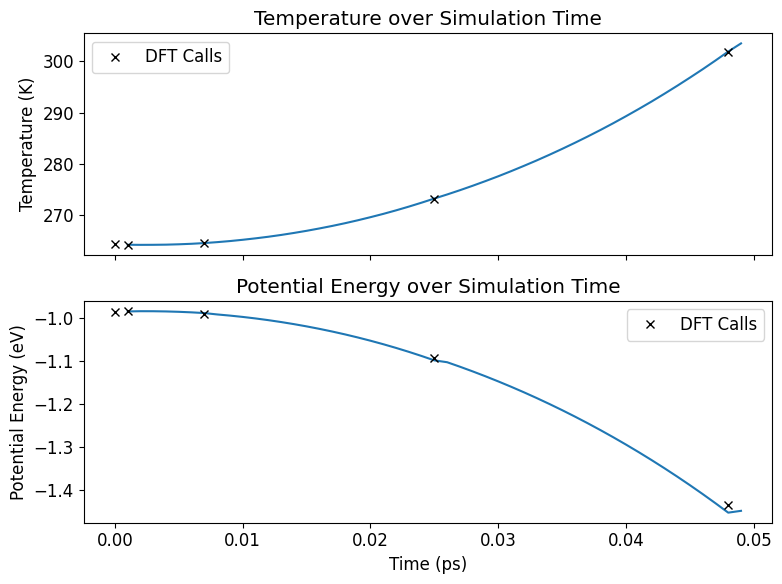

In [8]:
import matplotlib.pyplot as plt
from flare.io import otf_parser

output_file = 'Al_otf.out'
otf_trajectory = otf_parser.OtfAnalysis(output_file)

# Extract data for plotting
times = otf_trajectory.times
lj_times = otf_trajectory.dft_times # Renamed from eam_times

temps = otf_trajectory.thermostat['temperature']
lj_temps = otf_trajectory.gp_thermostat['temperature'] # Renamed from eam_temps

gp_energies = otf_trajectory.thermostat['potential energy']
lj_energies = otf_trajectory.gp_thermostat['potential energy'] # Renamed from eam_energies

# Create a figure with two subplots stacked vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True) # Adjusted figsize for shorter y-axis

# Plot 1: Temperature vs. Simulation Time
ax1.plot(times, temps)
ax1.plot(lj_times, lj_temps, 'kx', label='DFT Calls')
ax1.set_ylabel('Temperature (K)')
ax1.set_title('Temperature over Simulation Time')
ax1.legend()

# Plot 2: Potential Energy vs. Simulation Time
ax2.plot(times, gp_energies)
ax2.plot(lj_times, lj_energies, 'kx', label='DFT Calls')
ax2.set_xlabel('Time (ps)')
ax2.set_ylabel('Potential Energy (eV)')
ax2.set_title('Potential Energy over Simulation Time')
ax2.legend()

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()


We can also visualize the atomic uncertainties as the simulation progresses. In the example below, atoms are colored according to their predictive error: **red** atoms denote high uncertainty (which triggers a DFT call), while **blue** atoms indicate low uncertainty.

> Note: If your OTF run used `md_engine: PyLAMMPS`, or if you ran a FLARE LAMMPS simulation with uncertainty, these values are saved directly in the output files (*.xyz or LAMMPS dumps). (*See [Run LAMMPS with UQ](#scrollTo=Run_LAMMPS_with_UQ) for details*)

To visualize this, load your trajectory into [OVITO](https://www.ovito.org/) and use `color coding` to map the atom colors to the uncertainties.

<img src="https://github.com/mir-group/FLARE-Tutorials/raw/master/APS-2020/al.gif" width="100%">

### Generate coefficient files for LAMMPS

After training, you will probably want to deploy the force field to large-scale molecular dynamics in LAMMPS. To get the coefficient files for FLARE pair style in LAMMPS, you need the json file of the SGP calculator under the same folder as the training.

In the above example, it is `Al_flare.json`. Then run the simple script below, where `lmp.flare` is the name of the resulting coefficient file, and you can put your name as the contributor.




In [9]:
from flare.bffs.sgp.calculator import SGP_Calculator

sgp_calc, _ = SGP_Calculator.from_file("Al_otf_flare.json")
sgp_calc.build_map("lmp.flare", "your_name")


> **NOTE**: This script is useful for constructing potential files. You should keep it and can use it after restarting an active learning trajectory, offline training, etc.

If you have set `use_mapping: True` in the config file, the following three files will be generated in the current directory.

| File name | Description |
| --------- | ----------- |
| `lmp.flare`| LAMMPS potential file generated by FLARE, and used for MD |
| `L_inv_lmp.flare`, `sparse_desc_lmp.flare`| coefficient files used in LAMMPS for uncertainty predictions |

To use FLARE with LAMMPS (including using LAMMPS for active learning and production MD), please check out this later section: 👉 [**Active Learning with LAMMPS MD**](#scrollTo=Active_Learning_with_LAMMPS_MD).


# Restart an active-learning trajectory

Here, we provide an example script with which we can restart an active-learning simulation. This is useful, as one can encounter machine issues, or you can simply extend the length of your training trajectory if the first attempt was not sufficient.

> **NOTE**: Before you restart, we suggest you to either back up the previous trainining folder or run restarted training in a new folder, because some files will be overwritten.

Suppose a new folder `Al_restart` is created for restarting the training, you will need to copy the following files from the previous training (`Al_otf`) folder to the current folder:
- Al_otf_atoms.json
- Al_otf_checkpt.json
- Al_otf_dft.pickle
- Al_otf_flare.json

(Optional, only if you use LAMMPS MD in the training)
- lmp.flare
- sparse_desc_lmp.flare
- L_inv_lmp.flare

If you want to restart from a previous checkpoint (not the latest), for example, step 10. You just need to copy the four `Al_otf_*.*` files from `Al_otf_ckpt_10` folder into `Al_restart`.

In the following, a super simple `restart.yaml` file is used for the restarting.

In [10]:
# Clean up for rerun
%cd /content/
! rm -rf Al_restart

# Create dir and copy config file
! mkdir -p Al_restart
! cp FLARE-Tutorials/OTF/restart.yaml Al_restart

# Copy relevant files
! cp Al_otf/*.json Al_otf/*.pickle Al_restart

# Modify number of steps (temporary fix)
%cd Al_restart
! sed -i 's/number_of_steps: 20/number_of_steps: 80/g' restart.yaml
! cat restart.yaml

/content
/content/Al_restart
# Set up On-the-fly training and MD
otf: # On-the-fly training and MD
    mode: restart                                                               # Restart an active learning trajectory.
    number_of_steps: 80                                                         # set the maximum number of MD steps. This is not additive on previous steps. E.g., if you already ran a simulation for 10 steps, this restart set-up will stop at 20 total steps, not 10 + 20.
    checkpoint: Al_otf_checkpt.json                                   # Point to the checkpoint file from which you want to restart. The lmp.flare file also needs to be present in this directory.


In [11]:
! flare-otf restart.yaml

In [12]:
# Count the number of DFT frames
! echo "DFT frames in restart run: $(grep -c 'Lattice' Al_otf_dft.xyz)"
! echo "DFT frames in previous run: $(grep -c "Lattice" ../Al_otf/Al_otf_dft.xyz)"

# Combine all DFT frames
! cat Al_otf_dft.xyz ../Al_otf/Al_otf_dft.xyz > all_dft.xyz
! echo "All DFT frames collected: $(grep -c "Lattice" all_dft.xyz)"

DFT frames in restart run: 1
DFT frames in previous run: 5
All DFT frames collected: 6


# Evaluate Model Instantiation Parameters
Prior to the final training of any SGP model, the user should evaluate the model instantiation parameters, i.e., those parameters that are not optimized during training. These parameters build the descriptor representation of atomic environments in the FLARE framework, namely, the cutoff, n$_{max}$, and l$_{max}$. Here, we recommend using a bash script to build the directory structure, and tools like `sed` to easily replace strings of interest in the `yaml` files. We recommend the following ranges of parameters, which have found to be sufficient to scan for a variety of systems: cutoff = (3.0,9.0,1.0), n$_{max}$ = (2,14,2), and l$_{max}$ = (0,6,1). The highest marginal log likelihood, as well as the corresponding force, energy and stress MAEs, are all typically used to select the best model parameters, which can be parsed from the training files once completed. Since the number of force labels is highest, relative to energies and stresses, the force MAE is usually given the most weight in selecting the highest performance model. One should also keep in mind the total cost of the model when sweeping through model instantiation parameters, which grows with the dimension of the descriptor, and is expressed as:

$n_d$ = ($n_{max}$ $\cdot$ $n_{species}$ + 1) $\cdot$ $n_{max}$ $\cdot$ $\frac{n_{species}}{2}$ $\cdot$ ($l_{max}$ + 1).

We can then select appropriate model instantiation parameters that provide a minimum in the force MAE, while keeping the cost of the descriptor minimal. We can then perform another offline training on the entire dataset generated from our consecutive active-learning trajectories to yield the final FLARE potential. This is the final step in creating a FLARE potential for your workflow, where additional MD and uncertainty quantification steps can be found elsewhere.


# Offline training from available DFT data
We will train an SGP model from the DFT labels generated from our previous "on-the-fly" active-learning trajectory as an example of FLARE's utility on existing DFT labels (e.g., if you want to build a MLFF from an existing AIMD trajectory or relaxation pathway). An "offline" active learning `offline.yaml` config file is provided here, where we perform "Fake MD" on the already computed ground-truth DFT labels and build our SGP model from these frames. We also provide an example script that is able to take previously generated VASP `OUTCAR` files and convert them to `.extxyz` for easy use of the provided yaml script.

**Note: the offline training syntax also changed a bit. Explain if there are multiple xx_dft.xyz files**

**Only display and explain the different yaml blocks from the online training**

In the yaml file, you can keep the settings the same as the on-the-fly training, only changing the `supercell`, `dft_calc` and `md`:
```yaml
supercell:

```

```yaml
dft_calc:
```

```yaml
otf:
    ...same as on-the-fly
    md_engine:
    md_kwargs:
    ...same as on-the-fly
```

In [13]:
# Cleanup for rerun
%cd /content/
! rm -rf Al_offline

# Make offline training dir and copy config file
! mkdir -p Al_offline
! cp FLARE-Tutorials/OTF/offline.yaml Al_offline/Al_offline.yaml

# Copy all DFT data
! cp Al_restart/all_dft.xyz Al_offline

# Print config file
%cd Al_offline
! sed -i 's/Al_otf_dft.xyz/all_dft.xyz/g' Al_offline.yaml
! cat Al_offline.yaml

In [14]:
!flare-otf Al_offline.yaml

We can then check the number of DFT actually used during the offline training. Based on the uncertainty threshold defined in `offline.yaml`, the model selectively adds only the necessary frames to the sparse set, rather than including every previously collected DFT configuration. This prevents data redundancy, ensuring the model fits within memory limits during the GP training.

In [15]:
! echo "Training DFT frames: $(grep -c "Lattice" all_dft.xyz)"

! echo "Selected DFT frames: $(grep -o '"dft_count": [0-9]*' offline_checkpt.json | awk '{print $2}')"


Training DFT frames: 6
Selected DFT frames: 5


Hence, we have built our final FLARE potential from our previously generated DFT training labels, and can now perform production-level MD.

# Validation and Test

After a model is trained, we want to know the accuracy of the model. Notice that the mean absolute errors (MAEs) reported during the on-the-fly/offline training are not the real test error, since those are evaluated with the models at the current steps.

Here are a few approaches that we can use for testing the potential.

1. Use the LAMMPS coefficient file of the trained potential to run an MD with LAMMPS, and randomly pick up a few frames for DFT calculations. Then the error can be calculated by directly comparing the LAMMPS and DFT energy/forces/stress.

2. With extra AIMD data that are not used for training, there are two ways:
    -  Warm start an offline training with a very large `std_tolerance_factor`, such that no frame will be added to the model during the offline training, but each frame will be predicted and the MAE will be computed.
    - Use the [ASE LAMMPS Calculator](https://wiki.fysik.dtu.dk/ase/ase/calculators/lammps.html) or the [LAMMPS Python API](https://docs.lammps.org/Python_head.html) and the coefficient file of FLARE potential to make predictions on the frames.


# Active Learning with LAMMPS MD
Since we learned how to run on-the-fly training with FLARE and ASE MD engine, we now cover how to

- Deploy the trained FLARE Bayesian force field to large-scale MD in LAMMPS 👉 [Run LAMMPS MD with FLARE pair style and uncertainty](#scrollTo=Run_MD_in_LAMMPS_with_uncertainty)

- Use a faster and more flexible MD for the active learning 👉 [train FLARE force field on-the-fly with LAMMPS MD](#scrollTo=Set_up_training_config_with_LAMMPS)

> Why do we use LAMMPS MD for active learning?
>
> 1. ASE only provides very limited MD engines (Verlet, Langevin, NPT, etc.) and functionalities.
>
> 2. The energy/forces/stress are predicted by sparse GP force field, whose computational cost grows with increasing training set size, and can be slow as the training proceeds.

## Install LAMMPS with FLARE pair styles

The LAMMPS code files for FLARE are in the `flare/lammps_plugins` folder. We go to the folder and run the `install.sh`. Then we go to the `lammps` folder, and run `cmake` and `make` to compile the LAMMPS executable.

This can take 10 to 20 minutes.

In [16]:
%cd /content/
# Download LAMMPS
! rm -rf lammps && git clone --depth=1 https://github.com/lammps/lammps

In [17]:
# Run install script for FLARE LAMMPS
!cd flare/lammps_plugins && ./install.sh ../../lammps

# Compile LAMMPS
!cd lammps && mkdir -p build && cd build && cmake ../cmake -DPKG_MACHDYN=yes -DDOWNLOAD_EIGEN3=yes -DPKG_MANYBODY=yes && make -j$(nproc)

## Set up training config with LAMMPS

We will use the same Al structure `init_Al.xyz` created previously. Now, we will replace the `md_engine` and add `md_kwargs` under `otf` section.

The flexibility of LAMMPS allows us to use different `fix` commands, and grouping atoms using `region` and `group`. Here is an example
```yaml
otf:
    mode: fresh
    md_engine: PyLAMMPS
    md_kwargs:
        command: "lammps/build/lmp"
        specorder: [Al]
        dump_period: 10
        pair_style: flare
        region:
            - "bottom block INF INF INF INF INF 4.0\n"
        group:
            - "frozen region bottom"
            - "mobile subtract all frozen"
        fix:
            - "1 mobile nvt temp 2500 2500 $(100.0*dt)"
            - "2 frozen setforce 0 0 0"
```

Here, for quick demonstration, we use a classical EAM potential (whose coefficients are specified in the file `Al_zhou.eam.alloy`) for aluminum as the ground truth, instead of a real DFT calculator. This information can be found under `dft_calc` in `lammps.yaml` file.

An example of using VASP as the DFT calculator can be found [above](#scrollTo=Example_DFT_Setup) and more on [ASE's tutorial on VASP Calculator](https://wiki.fysik.dtu.dk/ase/ase/calculators/vasp.html).

In [27]:
# Cleanup if you want to modify config file and rerun
%cd /content/
! rm -rf Al_otf_lammps

# Copy EAM potential as our "DFT" calculation
! mkdir -p Al_otf_lammps && cp lammps/potentials/Al_zhou.eam.alloy ./Al_otf_lammps

# Copy initial structure and yaml config
! cp init_Al.xyz Al_otf_lammps/Al.xyz
! cp FLARE-Tutorials/OTF/lammps.yaml Al_otf_lammps

# Modify config file (temporary fix)
%cd Al_otf_lammps
! sed -i 's|lammps/build/lmp|../lammps/build/lmp|g' lammps.yaml
! sed -i 's/initial_velocity: 1000/initial_velocity: 500/g' lammps.yaml
! sed -i 's/1 all nve/1 all nvt temp 300 300 $(100.0*dt)/g' lammps.yaml
# ! sed -i 's/number_of_steps: 500/number_of_steps: 2000/g' lammps.yaml
! cat lammps.yaml

/content
/content/Al_otf_lammps
# Super cell is read from a file such as POSCAR, xyz, lammps-data
# or any format that ASE supports
supercell: 
    file: Al.xyz
    format: extxyz
    replicate: [1, 1, 1]
    jitter: 0.1

# Set up FLARE calculator with (sparse) Gaussian process
flare_calc:
    gp: SGP_Wrapper
    kernels:
        - name: NormalizedDotProduct
          sigma: 2.0
          power: 2
    descriptors:
        - name: B2
          nmax: 8
          lmax: 3
          cutoff_function: quadratic
          radial_basis: chebyshev
    energy_noise: 0.1
    forces_noise: 0.05
    stress_noise: 0.0006
    species:
        - 13
    single_atom_energies:
        - 0
    cutoff: 5.0
    variance_type: local
    max_iterations: 20
    use_mapping: True

# In the tutorial, we use LAMMPS Tersoff potential as ground truth
# instead of DFT to save time
dft_calc:
    name: LAMMPS
    kwargs: 
        command: "../lammps/build/lmp"
        label: al
        keep_tmp_files: True
        tmp_

## Run on-the-fly training
If you want to use OpenMP parallelization to speed up FLARE on your HPC, then set
```
export OMP_NUM_THREADS=<number_of_cpus_on_a_single_node>
```

To launch the training, in the command line, run `flare-otf <name>.yaml`.

In [28]:
! flare-otf lammps.yaml

In [20]:
# Zip file for download
# ! cd /content/ && zip -r Al_otf_lammps.zip Al_otf_lammps

### LAMMPS-Specific Output Files

Please refer to FLARE [Output files Section](#scrollTo=Output_files) and [Generate coefficient files for LAMMPS](#scrollTo=Generate_coefficient_files_for_LAMMPS)

## FLARE LAMMPS Postprocessing

In `myotf_thermo.txt`, the columns are

`step, temp, ke, pe, etotal, pxx, pyy, pzz, pyz, pxz, pxy, c_MaxUnc`

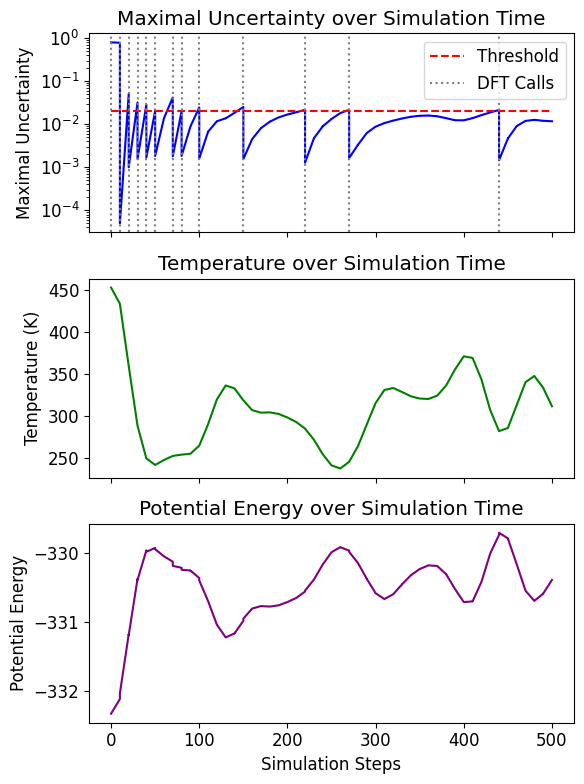

In [29]:
import matplotlib.pyplot as plt

# Read data
otf_data = np.loadtxt("myotf_thermo.txt")
steps = otf_data[:, 0] # 1 fs/step
max_uncertainty = otf_data[:, -1]
threshold = 0.02
temperatures = otf_data[:, 1]
potential_energies = otf_data[:, 3]

# Create a figure with three subplots stacked vertically
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 8), sharex=True)

# Plot 1: Maximal atomic uncertainty at each MD step
ax1.plot(steps, max_uncertainty, color="blue")
ax1.plot(steps, threshold * np.ones_like(steps), "--", color="red", label="Threshold")

# Plot DFT calls with grey dash lines
steps_above_threshold = steps[max_uncertainty > threshold]
for dft_step in steps_above_threshold:
    if dft_step == steps_above_threshold[0]:
        label = "DFT Calls"
    else:
        label = None
    ax1.axvline(dft_step, linestyle=":", color="grey", label=label)

ax1.set_ylabel("Maximal Uncertainty")
ax1.set_yscale("log")
ax1.set_title("Maximal Uncertainty over Simulation Time")
ax1.legend()

# Plot 2: Temperatures
ax2.plot(steps, temperatures, color="green")
ax2.set_ylabel("Temperature (K)")
ax2.set_title("Temperature over Simulation Time")

# Plot 3: Potential Energies
ax3.plot(steps, potential_energies, color="purple")
ax3.set_xlabel("Simulation Steps")
ax3.set_ylabel("Potential Energy")
ax3.set_title("Potential Energy over Simulation Time")

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()


## Coefficient files for LAMMPS

After the training is done, you will probably want to deploy the force field to large-scale molecular dynamics in LAMMPS. You need the coefficient files for FLARE pair styles (and compute commands if the uncertainty is needed to be calculated).

The following files are needed for running FLARE in LAMMPS:

- **Force field**: coefficient file `lmp.flare` for pair_flare energy/forces/stress. Can be a different file name. Used as

  ```
  pair_style	flare
  pair_coeff	* * lmp.flare
  ```

- **(Optional) SGP uncertainty**: coefficient files `sparse_desc_lmp.flare` and `L_inv_lmp.flare` for sparse GP uncertainty calculation. Can be different file names. Used as

  ```
  compute unc all flare/std/atom L_inv_lmp.flare sparse_desc_lmp.flare
  ```

  Note: this is the exact SGP uncertainty, and its computational cost grows quadratically with the sparse set size.

- **(Optional) Mapped uncertainty**: coefficient file  `mapped_unc_lmp.flare` for mapped uncertainty calculation. Can be a different file name. Used as

  ```
  compute unc all flare/std/atom map_unc_lmp.flare
  ```

  Note:
  1. This is the mapped uncertainty which is an approximation of the exact SGP uncertainty with a much cheaper computational cost comparable to the force field. See details in [this paper](https://arxiv.org/abs/2203.03824).
  2. Basically, when there are two coefficient files after `compute unc all flare/std/atom` it will calculate the exact SGP uncertainty, when there is one coefficient file it will calculate the mapped uncertainty.

If `map_uncertainty=True`, the mapped uncertainty coefficient file `map_unc_lmp.flare` will be generated instead of `sparse_desc_lmp.flare` and `L_inv_lmp.flare`. It might take a while because a new SGP with `power=1` kernel will be constructed and mapped.

To generate cofficient files for LAMMPS after training, please refer to section: [Generate coefficient files for LAMMPS](#scrollTo=Generate_coefficient_files_for_LAMMPS)

## Run LAMMPS with UQ

Prepare a LAMMPS data file.


> **Note**: if you are using ASE to write a LAMMPS data file, be careful of the species order. Make sure you set up the `specorder` to the list of the elements with the same order specified in the yaml file of the on-the-fly training. Otherwise, ASE will assign type ID to atoms based on the order of their chemical numbers by default. The inconsistency between the atomic type ID and the potential type order will make the energy/forces/stress prediction wrong.

In [30]:
# Convert xyz to lammps.data
! mkdir -p lammps_run

from ase.io import read, write
atoms = read("Al.xyz")
write("lammps_run/Al.data", atoms, format="lammps-data", specorder=["Al"])


Prepare FLARE coefficient files and the LAMMPS input file. Here, we set up an $NVT$ run at 300 K.

In [31]:
# Copy FLARE coefficient files for LAMMPS MD run with UQ
! cp lmp.flare L_inv_lmp.flare sparse_desc_lmp.flare lammps_run/

# Copy LAMMPS input script
! cp ../FLARE-Tutorials/OTF/lammps.in lammps_run/

# Run more total steps
! sed -i 's/run 1000/run 4000/g' lammps_run/lammps.in
! cat lammps_run/lammps.in

log log.lammps

units	metal
atom_style atomic
newton on

read_data Al.data

pair_style	flare
pair_coeff	* * lmp.flare

compute unc all flare/std/atom L_inv_lmp.flare sparse_desc_lmp.flare
compute MaxUnc all reduce max c_unc

mass            1 26.98

velocity all create 300.0 4928459 rot yes dist gaussian
fix 1 all nvt temp 300 300 $(100.0*dt)
dump dump_all all custom 10 output.dump id type x y z fx fy fz c_unc
thermo 10
thermo_style custom step temp pe etotal press vol c_MaxUnc

run 4000


Run LAMMPS

In [32]:
! cd lammps_run && ../../lammps/build/lmp -in lammps.in

LAMMPS (10 Dec 2025 - Development - 3eacc1d-modified)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread.
  using 1 OpenMP thread(s) per MPI task
Reading data file ...
  triclinic box = (0 0 0) to (11.45513 9.9204335 31.691343) with tilt (5.7275649 0 0)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  97 atoms
  read_data CPU = 0.001 seconds
Reading potential file lmp.flare with DATE: Fri
Reading potential file L_inv_lmp.flare with DATE: Fri
Reading potential file sparse_desc_lmp.flare with DATE: Fri
Neighbor list info ...
  update: every = 1 steps, delay = 0 steps, check = yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 7
  ghost atom cutoff = 7
  binsize = 3.5, bins = 5 3 10
  2 neighbor lists, perpetual/occasional/extra = 1 1 0
  (1) pair flare, perpetual
      attributes: full, newton on
      pair build: full/bin/atomonly
      stencil: full/bin/3d
      bin: standard
  (2) compute flare/std/atom, occasional, copy from (1)
      

### Visualize LAMMPS trajectory with UQ

If you just run the on-the-fly training with using `md_engine: PyLAMMPS` **OR** if you added the following commands to your LAMMPS input script:

```
compute unc all flare/std/atom L_inv_lmp.flare sparse_desc_lmp.flare
compute MaxUnc all reduce max c_unc

dump dump_all all custom 10 output.dump id type x y z fx fy fz c_unc
thermo_style custom step temp pe etotal press vol c_MaxUnc
```

**Where to find the data**

* **Trajectory (`output.dump`)**: The atomic uncertainty is recorded in the final column, labeled `c_unc`.
* **Thermodynamic Output (LAMMPS `log`)**: The maximal atomic uncertainty for each timestep is recorded in the final column, labeled `c_MaxUnc`.

**Visualization**: You can visualize the dumped trajectory using [OVITO](https://www.ovito.org). Simply load `output.dump` and apply the `Color coding` modifier to the `c_unc` property to map the atoms' colors to their uncertainty values.

<img src="https://github.com/mir-group/FLARE-Tutorials/raw/master/APS-2020/al.gif" width="100%">

### Monitor uncertainty and other quantities

Here we plot the temperature and maximal atomic uncertainty with the simulation time. The data is extracted from the LAMMPS log file, using a python package `lammps-logfile`.

In [25]:
! pip install lammps-logfile

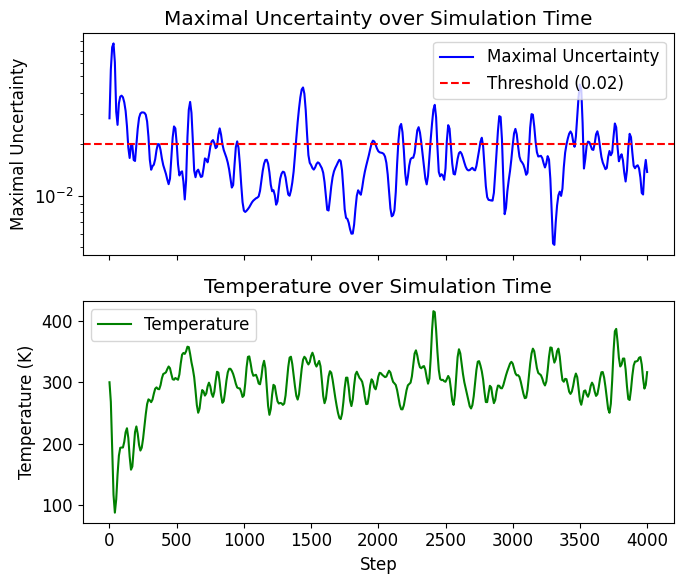

In [33]:
import matplotlib.pyplot as plt
import lammps_logfile
import numpy as np

log = lammps_logfile.File("lammps_run/log.lammps")
steps = log.get("Step")
max_uncertainty = log.get("c_MaxUnc")
temperatures = log.get("Temp")

threshold = 0.02 # Define the threshold for uncertainty

# Create a figure with two subplots stacked vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 6), sharex=True)

# Plot 1: Maximal atomic uncertainty
ax1.plot(steps, max_uncertainty, color="blue", label="Maximal Uncertainty")
ax1.axhline(y=threshold, color="red", linestyle="--", label=f"Threshold ({threshold})")
ax1.set_ylabel("Maximal Uncertainty")
ax1.set_yscale("log")
ax1.set_title("Maximal Uncertainty over Simulation Time")
ax1.legend()

# Plot 2: Temperature
ax2.plot(steps, temperatures, color="green", label="Temperature")
ax2.set_xlabel("Step")
ax2.set_ylabel("Temperature (K)")
ax2.set_title("Temperature over Simulation Time")
ax2.legend()

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

We can use the **maximal atomic uncertainty** to monitor model confidence, and qualify how far the current configuration deviates from the training data. This metric is very helpful to detect potential unphysical behavior or extrapolation during the simulation.

In the figure above, we observe that the uncertainty remains consistently below the defined threshold (0.02) as the system equilibrates around 300 K, which corresponds to the target temperature of our active learning trajectory. Practically speaking, however, collecting data across a range of **varied temperatures** is often recommended to improve the model's robustness."

# References

[1] Jonathan Vandermause, Yu Xie, Jin Soo Lim, Cameron J. Owen, Boris Kozinsky. Active learning of reactive Bayesian force fields applied to heterogeneous catalysis dynamics of H/Pt. Nat Commun 13, 5183 (2022).

[2] Anders Johansson, Yu Xie, Cameron J. Owen, Jin Soo Lim, Lixin Sun, Jonathan Vandermause, Boris Kozinsky. Micron-scale heterogeneous catalysis with Bayesian force fields from first principles and active learning. https://arxiv.org/abs/2204.12573

[1] S. Chmiela, A. Tkatchenko, H. E. Sauceda, I. Poltavsky, K. T. Schütt, K.-R. Müller. Sci. Adv. 3(5), e1603015, 2017.

[2] K. T. Schütt, F. Arbabzadah, S. Chmiela, K.-R. Müller, A. Tkatchenko. Nat. Commun. 8, 13890, 2017.

[3] S. Chmiela, H. E. Sauceda, K.-R. Müller, A. Tkatchenko. Nat. Commun. 9, 3887, 2018.

[4] Bartók, A. P., Payne, M. C., Kondor, R., & Csányi, G. (2010). Physical review letters, 104(13), 136403.

[5] Bartók, A. P., & Csányi, G. (2015). International Journal of Quantum Chemistry, 115(16), 1051-1057.

[6] Drautz, R. (2019). Physical Review B, 99(1), 014104.